In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [30]:
# read tariff dataset
path = '../Dataset/Power Networks/'
filename = 'Tariffs.xlsx'
t = time.time()
df = pd.read_excel(path+filename)
elapsed = time.time() - t

In [3]:
df.columns
# df['Tariff'].unique()
fig_path = '../Figures/'

In [4]:
# read timeseries
ts = pd.read_csv(path+'Power-Networks-LCL-June2015(withAcornGps).csv_Pieces/2013_agg_dates.csv')

# Functions

In [5]:
# function that converts series of signals to pairs
# used to draw background colors on the plot
def start_end_signal(df):
    high_l = []
    for i, idx in enumerate(df['index']):
        if i == 0:
            start = idx 
        else:
            if (prev_idx + 1) == idx:
                end = idx
            else:
                high_l.append([start, end])
                start = idx
                end =idx
        prev_idx = idx
    end = idx
    high_l.append([start, end])
    return(high_l)

In [6]:
# get name of day
def name_day(year, month, day):
    ans = calendar.weekday(year,month,day)
    return calendar.day_name[ans]

In [14]:
# get name of month
def name_month(val):
    if (val == 1):
        month = 'January'
    elif (val == 2):
        month = 'February'
    elif (val == 3):
        month = 'March'
    elif (val == 4):
        month = 'April'
    elif (val == 5):
        month = 'May'
    elif (val == 6):
        month = 'June'
    elif (val == 7):
        month = 'July'
    elif (val == 8):
        month = 'August'
    elif (val == 9):
        month = 'September'
    elif (val == 10):
        month = 'October'
    elif (val == 11):
        month = 'November'
    elif (val == 12):
        month = 'December'
    else:
        month = 'Not Existing Month'
    return month

In [7]:
# convert string to index
def convert_to_num(val):
    if val == 'Normal':
        rval = 0
    elif val == 'Low':
        rval = -1
    else:
        rval = 1
    return rval

In [8]:
# convert string to price
def add_price(val):
    if val == 'Normal':
        rval = 11.76
    elif val == 'Low':
        rval = 3.99
    else:
        rval = 77.2
    return rval

In [ ]:
# get number of week
def week_number(year, month, day):
    return dt.date(year, month, day).isocalendar()[1]

# Edit Tariff dataset

In [31]:
df['Tindex'] = df['Tariff'].apply(convert_to_num) # Strings to index
df['Price'] = df['Tariff'].apply(add_price) # Add pricing

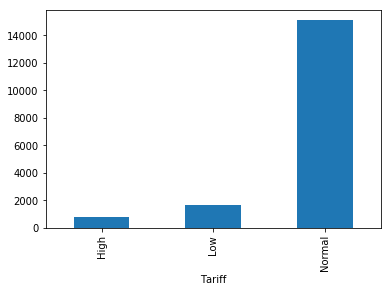

In [32]:
df.groupby('Tariff').size().plot(kind = 'bar') # plot counts of each signal

In [33]:
# Add Month, Hour, Day, Minute Columns
df['Month'] = df['TariffDateTime'].dt.month
df['Hour'] = df['TariffDateTime'].dt.hour
df['Day'] = df['TariffDateTime'].dt.day
df['Minute'] = df['TariffDateTime'].dt.minute

In [34]:
# add names of months
df['MonthName'] = df['Month'].apply(name_month) 

In [35]:
# Give names and numbers for days and week
df['DayName'] = df.apply(lambda row: name_day(2013, row['Month'], row['Day']), axis = 1)
df['Weekday'] = df.apply(lambda row: calendar.weekday(2013, row['Month'], row['Day']), axis = 1)
df['WeekNumber'] = df.apply(lambda row: week_number(2013, row['Month'], row['Day']), axis =1)

# Comparison of ToU and STD

In [42]:
sample = df.loc[df['WeekNumber'] == 3]
sample = sample.loc[df['Day'] == 19]
# sample = df.loc[df['Month'] == 1]

# nice visuals on 5, 3, 8, 9
sample.shape
ts['DateTime'] = pd.to_datetime(ts['DateTime'])
ts = ts.loc[ts['Acorn_grouped'] == 'Adversity']

In [43]:
mergedsample = pd.merge(sample[['TariffDateTime', 'Tariff', 'Tindex']], ts, how = 'inner', left_on= 'TariffDateTime', right_on= 'DateTime')

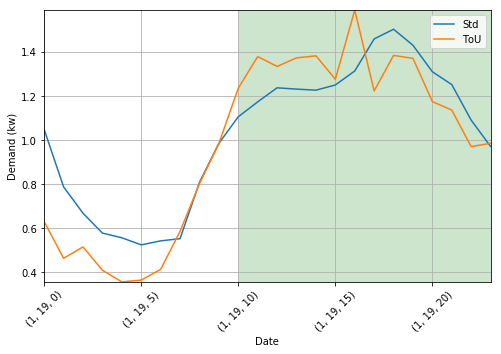

In [44]:
x = [i for i in range(0, sample.shape[0])] #fake data
y = [5 for i in range(0, sample.shape[0])]

fig, ax = plt.subplots(figsize = (8,5))


# Plot the lines
for group in mergedsample['stdorToU'].unique():
    count = mergedsample['LCLid'].loc[mergedsample['stdorToU'] == group].nunique()
    mergedsample.loc[mergedsample['stdorToU'] == group].groupby(['Month', 'Day', 'Hour'])['kw'].apply(lambda row: row.sum()/count).plot(kind= 'line', label = group)
plt.legend(loc = 'upper right')

ax.grid()
ax.margins(0) # remove default margins (matplotlib verision 2+)

# Plot the background color for high singals
sample['index'] = [i for i in range(0, sample.shape[0])]
high = sample[['WeekNumber', 'Day', 'Hour', 'index']].loc[sample['Tariff'] == 'High']
if high.shape[0] != 0: # access if data exist
    list_h = start_end_signal(high) # get list from series
    for pair in list_h:# iterate over pairs and plot
        ax.axvspan(pair[0], pair[1], facecolor='red', alpha=0.2)

# Plot the background color for low singals
low = sample[['WeekNumber', 'Day', 'Hour', 'index']].loc[sample['Tariff'] == 'Low']
if low.shape[0] != 0: # access if data exist
    list_l = start_end_signal(low) # get list from series
    for pair in list_l: # iterate over pairs and plot
        ax.axvspan(pair[0], pair[1], facecolor='green', alpha=0.2)
        
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Demand (kw)')
plt.savefig(fig_path+'Demand for different tarrifs.png')
plt.show()